# Hyperparameter optimisation

Notebook to do hyperparameter optimisation

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, \
    precision_recall_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing.label import LabelBinarizer
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase, Classifier, Regression, Stacked
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, PerElementOperator, CVOperator, df_cv_split
from utils import make_plots, pr

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Split the training data into folds respecting the breakpoints.

In [3]:
breakpoint_df = pd.read_csv('data/cagi5_bkpt.csv').astype({'chunk_id': int})
breakpoint_df.loc[breakpoint_df['is_break'] != 'no']

,Unnamed: 0,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id
0,0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.930,1.4900,start,NaN,True,0
47,47,X,138612684,G,T,-0.02,0.00,0,release_F9,0.048,-0.233,3.450,-2.0100,end,16.0,False,0
48,48,X,138612701,T,A,-0.36,0.37,-1,release_F9,0.009,0.470,3.270,1.9200,start,NaN,True,1
95,95,X,138612716,G,T,-0.15,0.04,0,release_F9,0.055,0.581,3.320,0.4310,end,16.0,False,1
96,96,X,138612765,C,A,0.07,0.01,0,release_F9,0.420,-0.304,4.220,0.2990,start,NaN,True,2
143,143,X,138612780,T,G,0.18,0.02,0,release_F9,0.525,0.470,4.690,4.6900,end,16.0,False,2
144,144,X,138612877,G,A,-0.09,0.05,0,release_F9,0.864,0.581,5.080,5.0800,start,NaN,True,3
190,190,X,138612892,C,T,0.12,0.01,0,release_F9,0.508,0.581,5.080,1.7900,end,16.0,False,3
191,191,X,138612909,C,A,0.05,0.02,0,release_F9,0.453,0.581,5.080,0.0736,start,NaN,True,4
235,235,X,138612924,A,G,-0.01,0.00,0,release_F9,0.614,0.470,4.550,0.6710,end,16.0,False,4


In [4]:
def folds_from_chunks(df, nfolds=3, foldcol='fold', permute=True):
    """
    Labels each sample with a fold identifier. Chunks are respected in that
    each chunk is only ever in a single fold. The data frame is modified in place.
    """
    df[foldcol] = -1
    for elem in df['regulatory_element'].unique():
        iselem = df['regulatory_element'] == elem
        chunkids = np.random.permutation(list(set(df.loc[iselem]['chunk_id'])))
        for k, chunk in enumerate(chunkids):
            ischunk = df['chunk_id'] == chunk
            df.loc[iselem & ischunk, foldcol] = k % nfolds
    assert np.all(df[foldcol] != -1)  # double check we allocated each sample a fold
df = breakpoint_df
nfolds = 3
folds_from_chunks(df, nfolds=nfolds, foldcol='outer')
for o in range(nfolds):
    outertrain = df['outer'] == o
    outervalid = df['outer'] != o

## Create features

In [5]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
dnase = DNase()
subst = SubstitutionOneHot()
enhancer1hot = EnhancerOneHot()
snpcontext2 = SNPContext(context_size=2)
snpcontext4 = SNPContext(context_size=4)
conservation = Conservation()
stacked = Stacked('deep-dnase-cons')
features = np.concatenate(
    (
        deepseadiffs.get_features(breakpoint_df),
        dnase.get_features(breakpoint_df),
        conservation.get_features(breakpoint_df),
    ),
    axis=1)

### Regressor

In [45]:
from xgboost import XGBRegressor
from multiprocessing import cpu_count
reg = XGBRegressor(n_jobs=cpu_count() - 1)
reg.get_params().keys()

dict_keys(['seed', 'colsample_bytree', 'missing', 'objective', 'base_score', 'booster', 'scale_pos_weight', 'silent', 'n_jobs', 'subsample', 'reg_lambda', 'nthread', 'max_delta_step', 'gamma', 'min_child_weight', 'learning_rate', 'max_depth', 'reg_alpha', 'colsample_bylevel', 'random_state', 'n_estimators'])

### Hyperparameter space

In [53]:
space = [
    Integer(6, 9, name='max_depth'),
    Real(.5, 1., name='subsample'),
    Real(.5, 1., name='colsample_bytree'),
    Real(.01, .04, name='reg_alpha'),
    Real(.01, 10., name='reg_lambda'),
    Real(.01, .4, name='learning_rate'),
    Real(.1,  10., name='min_child_weight'),
]
breakpoint_df.columns

Index(['Unnamed: 0', '#Chrom', 'Pos', 'Ref', 'Alt', 'Value', 'Confidence',
       'class', 'regulatory_element', 'phastCon', 'phyloP', 'GerpN', 'GerpRS',
       'is_break', 'chunk_length', 'is_start', 'chunk_id', 'outer', 'inner',
       'PredValue'],
      dtype='object')

### Objective function

In [54]:
def logit(x):
    return np.log(x / (1 - x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
print(logit(sigmoid(-.45)))
print(sigmoid(logit(.45)))

-0.44999999999999996
0.44999999999999996


In [55]:
def objective_(**params):
    reg.set_params(**params)
    folds_from_chunks(df, nfolds=nfolds, foldcol='inner')
    for i in range(nfolds):
        innertrain = df['inner'] != i
        innervalid = df['inner'] == i
        train = outertrain & innertrain
        valid = outertrain & innervalid
        reg.fit(features[train], df.loc[train, 'Value'])
        df.loc[valid, 'PredValue'] = reg.predict(features[valid])
    precision, recall, thresholds, auprc = pr(df.loc[outertrain])
    return -logit(auprc)
objective = use_named_args(space)(objective_)

### Optimise

In [56]:
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


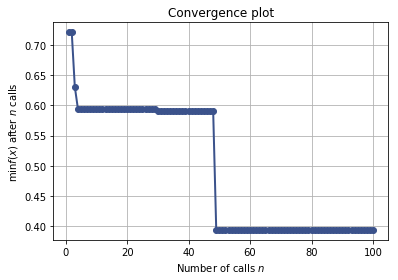

In [57]:
plot_convergence(res_gp)

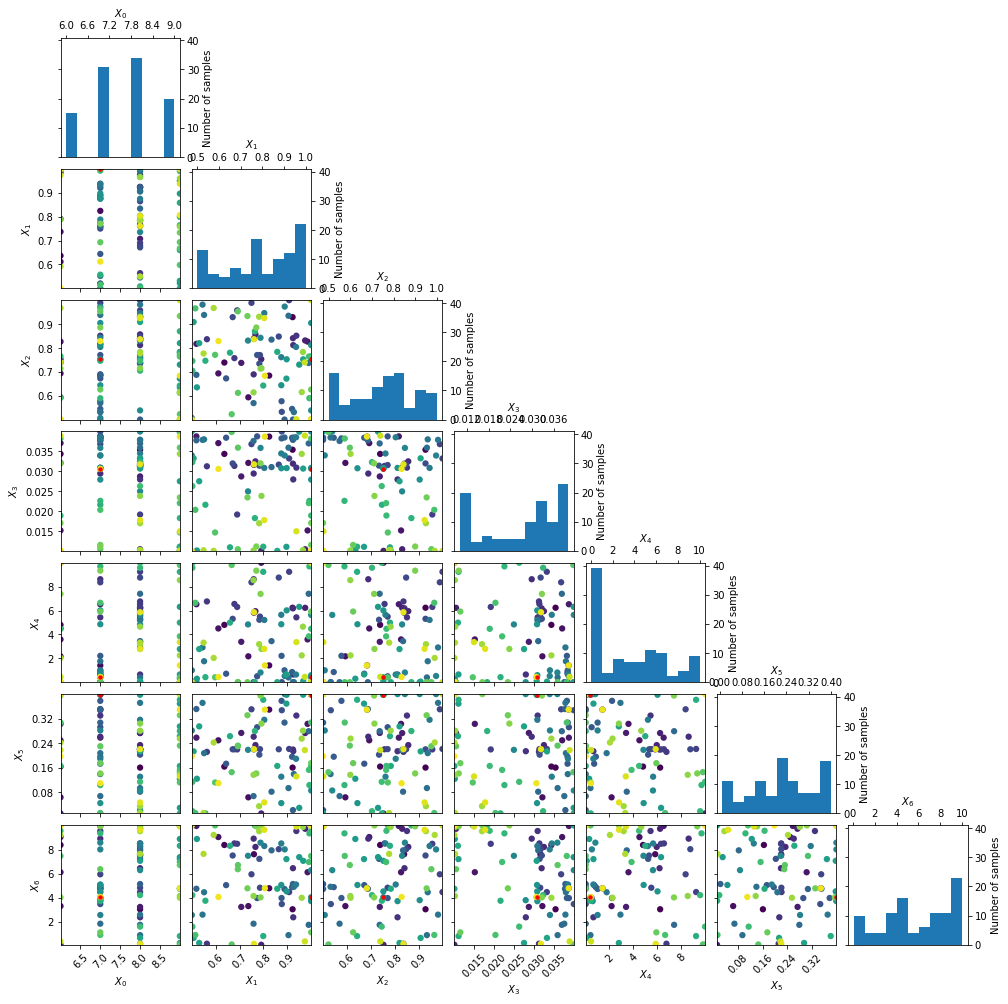

In [58]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(res_gp, bins=10)

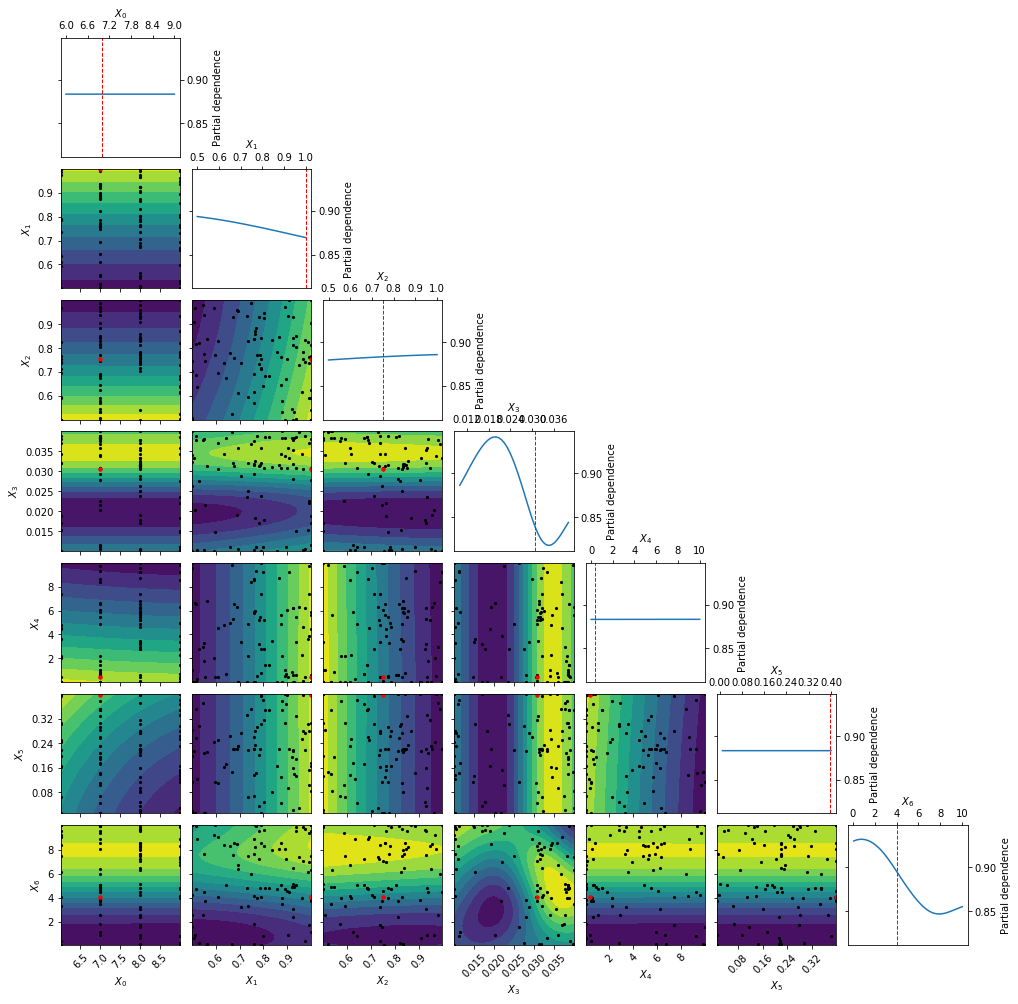

In [59]:
from skopt.plots import plot_objective
_ = plot_objective(res_gp)

In [60]:
print(res_gp.x)
"Best AUPRC=%.4f" % sigmoid(-res_gp.fun)

[7, 1.0, 0.7524052235178577, 0.030682622499703896, 0.40505823486422077, 0.39783003619093765, 4.0467095559059505]


'Best AUPRC=0.4028'

## Test on held-out data

In [61]:
kwargs = dict((param.name, x) for param, x in zip(space, res_gp.x))
kwargs

{'colsample_bytree': 0.7524052235178577,
 'learning_rate': 0.39783003619093765,
 'max_depth': 7,
 'min_child_weight': 4.0467095559059505,
 'reg_alpha': 0.030682622499703896,
 'reg_lambda': 0.40505823486422077,
 'subsample': 1.0}

In [14]:
maxauprc = sigmoid(-objective_(**kwargs))
maxauprc

0.29440128553117256

## Nested hyperparameter tuning

In [28]:
import numpy as np
from sklearn.model_selection import KFold, GroupKFold

# Set up possible values of parameters to optimize over
params={
    'max_depth': [2], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [1000], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset.
# E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
inner_cv = KFold()
outer_cv = GroupKFold()

def score_func(y, y_pred):
    precision, recall, thresholds = \
        precision_recall_curve(np.abs(y) > .1, np.abs(y_pred))
    auprc = auc(recall, precision)
    return auprc
scorer = make_scorer(score_func, greater_is_better=True)
    
    
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=reg, param_grid=params, cv=inner_cv)
nested_score = cross_val_score(
    clf,
    X=features,
    y=df['Value'],
    scoring=scorer,
    groups=df['chunk_id'],
    cv=outer_cv)

In [29]:
nested_score

array([0.69050258, 0.56394992, 0.67531142])